In [1]:
# Q1(a): Clean CRSP data
import pandas as pd
import numpy as np

# 1. Load the CRSP CSV, parsing dates
crsp = pd.read_csv('crsp_1926_2020.csv', parse_dates=['date'])

# 2. Keep only ordinary/common shares (SHRCD 10 or 11)
crsp = crsp[crsp['SHRCD'].isin([10, 11])]

# 3. Restrict to NYSE, AMEX, NASDAQ listings (EXCHCD 1, 2, 3)
crsp = crsp[crsp['EXCHCD'].isin([1, 2, 3])]

# 4. Mask negative prices (no‐trade indicators) as NaN
crsp['PRC'] = crsp['PRC'].mask(crsp['PRC'] < 0)

# 5. Save cleaned dataset
crsp_clean = crsp.copy()

# Quick check
crsp_clean.head()


,PERMNO,date,SHRCD,EXCHCD,PRC,RET,SHROUT
1,10000,1986-01-31,10.0,3.0,NaN,C,3680.0
2,10000,1986-02-28,10.0,3.0,NaN,-0.257143,3680.0
3,10000,1986-03-31,10.0,3.0,NaN,0.365385,3680.0
4,10000,1986-04-30,10.0,3.0,NaN,-0.098592,3793.0
5,10000,1986-05-30,10.0,3.0,NaN,-0.222656,3793.0


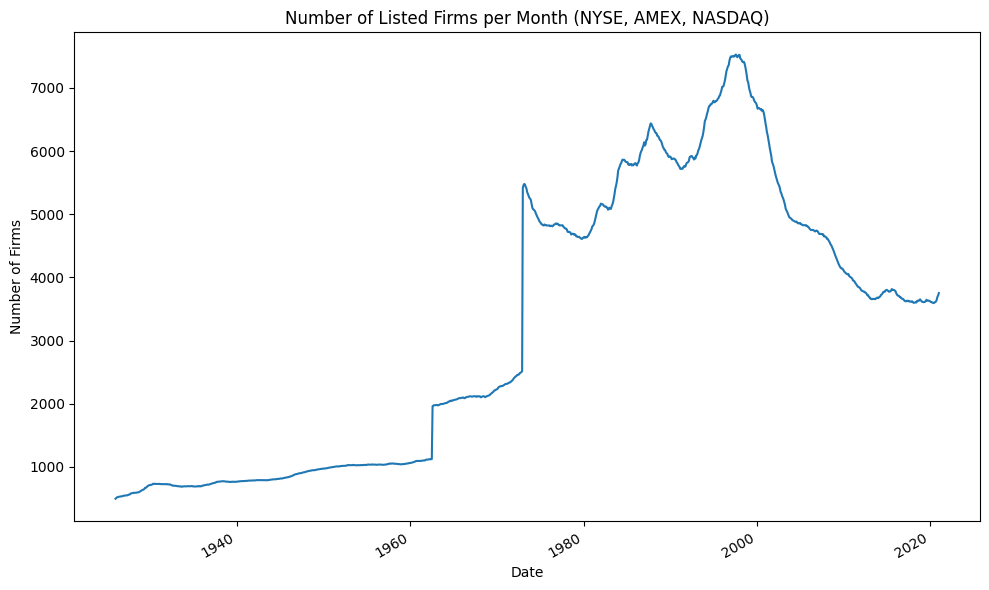

In [2]:
# Q1(b): Plot number of unique firms each month
import matplotlib.pyplot as plt

# Count distinct PERMNO per date
monthly_counts = crsp_clean.groupby('date')['PERMNO'].nunique()

# Plot time series
plt.figure(figsize=(10, 6))
monthly_counts.plot()
plt.title('Number of Listed Firms per Month (NYSE, AMEX, NASDAQ)')
plt.xlabel('Date')
plt.ylabel('Number of Firms')
plt.tight_layout()
plt.show()


In [3]:
# Q2(a): Form equal‐ and value‐weighted size‐decile portfolios
import numpy as np

# Clean CRSP data from Q1
df = crsp_clean.copy()

# ensure RET numeric & compute market equity
df['RET'] = pd.to_numeric(df['RET'], errors='coerce')
df['ME']  = df['PRC'] * df['SHROUT']

# drop any rows missing RET or ME
df = df.dropna(subset=['RET', 'ME'])

# assign size decile (1=smallest … 10=largest) each month
df['size_decile'] = (
    df.groupby('date')['ME']
      .transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)
)

# equal‐weighted returns: mean RET per decile
ew_ret = (
    df.groupby(['date','size_decile'])['RET']
      .mean()
      .unstack('size_decile')
      .sort_index(axis=1)
)

# value‐weighted returns: ME‐weighted RET per decile
vw_ret = (
    df.assign(wret = df['ME'] * df['RET'])
      .groupby(['date','size_decile'])
      .apply(lambda g: g['wret'].sum() / g['ME'].sum())
      .unstack('size_decile')
      .sort_index(axis=1)
)

# shapes
print("EW shape:", ew_ret.shape, "  VW shape:", vw_ret.shape)


EW shape: (1140, 10)   VW shape: (1140, 10)


/var/folders/h2/hsh48ttn3ngf0zf409hw9b0h0000gn/T/ipykernel_14716/951588481.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g['wret'].sum() / g['ME'].sum())


In [4]:
# Q2(b): Mean monthly returns by decile & monotonicity check

# calculate mean return for each decile
mean_ew = ew_ret.mean()
mean_vw = vw_ret.mean()

# check if means strictly decrease from decile 1→10
mono_ew = mean_ew.diff().iloc[1:].le(0).all()
mono_vw = mean_vw.diff().iloc[1:].le(0).all()

print("EW means:\n", mean_ew)
print("Monotonic decreasing?", mono_ew, "\n")
print("VW means:\n", mean_vw)
print("Monotonic decreasing?", mono_vw)


EW means:
 size_decile
1    -0.004880
2     0.011931
3     0.013317
4     0.015218
5     0.017156
6     0.017554
7     0.017618
8     0.017618
9     0.016298
10    0.014875
dtype: float64
Monotonic decreasing? False 

VW means:
 size_decile
1     0.001234
2     0.012194
3     0.013343
4     0.015360
5     0.017186
6     0.017498
7     0.017559
8     0.017456
9     0.016104
10    0.014391
dtype: float64
Monotonic decreasing? False


In [5]:
# Q2(c): Build SMB = Small(1) − Big(10) and report stats

# construct SMB series
smb_ew = ew_ret[1] - ew_ret[10]
smb_vw = vw_ret[1] - vw_ret[10]

# compute mean, volatility, and Sharpe
for label, series in [('EW SMB', smb_ew), ('VW SMB', smb_vw)]:
    m   = series.mean()
    vol = series.std()
    sr  = m / vol
    print(f"{label:<8} → Mean: {m:.4f}, Vol: {vol:.4f}, Sharpe: {sr:.2f}")


EW SMB   → Mean: -0.0198, Vol: 0.0889, Sharpe: -0.22
VW SMB   → Mean: -0.0132, Vol: 0.0855, Sharpe: -0.15


In [6]:
# Q2(d): CAPM & FF3 regressions on each size decile (EW & VW)
import statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

# 1. Load and clean Fama–French factors, skipping headers & footers
ff = pd.read_csv(
    'F-F_Research_Data_Factors.CSV',
    skiprows=3,
    names=['ym','Mkt-RF','SMB','HML','RF'],
    usecols=[0,1,2,3,4],
    engine='python'
)
# keep only rows where ym is exactly 6 digits (YYYYMM)
ff = ff[ff['ym'].astype(str).str.match(r'^\d{6}$')].copy()
# construct proper date index (month‐end)
ff['date'] = pd.to_datetime(ff['ym'].astype(str), format='%Y%m') + MonthEnd(0)
# convert from % to decimals
for col in ['Mkt-RF','SMB','HML','RF']:
    ff[col] = ff[col].astype(float) / 100
ff = ff.set_index('date')[['Mkt-RF','SMB','HML','RF']]

# 2. Run regressions and collect alphas
alpha_results = {}
for label, ret_df in [('EW', ew_ret), ('VW', vw_ret)]:
    for model, factors in [('CAPM', ['Mkt-RF']), ('FF3', ['Mkt-RF','SMB','HML'])]:
        key = f"{label}_{model}"
        alphas = []
        for decile in sorted(ret_df.columns):
            # align returns with factors
            port = ret_df[decile].rename('R')
            dfm  = pd.concat([port, ff], axis=1, join='inner').dropna()
            y    = dfm['R'] - dfm['RF']
            X    = sm.add_constant(dfm[factors])
            fit  = sm.OLS(y, X).fit()
            alphas.append(fit.params['const'])
        alpha_results[key] = alphas

# put into DataFrame
alpha_df = pd.DataFrame(alpha_results, index=sorted(ew_ret.columns))
alpha_df.index.name = 'Size Decile'
alpha_df


,EW_CAPM,EW_FF3,VW_CAPM,VW_FF3
Size Decile,,,,
1,-0.018566,-0.021695,-0.012392,-0.015317
2,-0.001746,-0.004340,-0.001425,-0.003998
3,0.000892,-0.001000,0.000874,-0.001000
4,0.002948,0.001427,0.003102,0.001582
5,0.005219,0.003949,0.005252,0.003990
6,0.006125,0.005067,0.006111,0.005078
7,0.006479,0.005727,0.006486,0.005752
8,0.006765,0.006234,0.006685,0.006178
9,0.006319,0.005948,0.006103,0.005748


2D

How alphas change:
- Alphas rise with size. Smaller deciles have negative alphas/larger deciles have positive alphas --> monotonic increase.
- FF3 reduces alpha magnitudes. Adding FF3 shrinks alphas, showing better model fit than CAPM alone.
- Equal-weighted portfolios show more extreme alphas. Small-cap effects are more pronounced when every stock is weighted equally.
- Large firms align better with models. Value-weighted portfolios show smoother, less negative alphas for small firms, suggesting model predictions fit large firms better.

In [7]:
# Q2(e): SMB performance in full sample and subperiods

period_summaries = {
    'Full Sample'  : smb_ew,
    'Pre‑Jun 1992' : smb_ew[:'1992-06-30'],
    'Post‑Jun 1992': smb_ew['1992-07-01':],
    'Post‑Jan 2002': smb_ew['2002-01-01':],
}

print("SMB Statistics (mean, vol, Sharpe):\n")
for name, series in period_summaries.items():
    m   = series.mean()
    vol = series.std()
    sr  = m / vol
    print(f"{name:<15} → Mean: {m:.4f}, Vol: {vol:.4f}, Sharpe: {sr:.2f}")


SMB Statistics (mean, vol, Sharpe):

Full Sample     → Mean: -0.0198, Vol: 0.0889, Sharpe: -0.22
Pre‑Jun 1992    → Mean: -0.0111, Vol: 0.0959, Sharpe: -0.12
Post‑Jun 1992   → Mean: -0.0400, Vol: 0.0659, Sharpe: -0.61
Post‑Jan 2002   → Mean: -0.0350, Vol: 0.0553, Sharpe: -0.63


The size strategy does not work in this sample. SMB delivers negative returns and Sharpe ratios across every period.  

The classic size tilt not only vanishes but reverses after Fama–French (1992) and remains unprofitable after 2002.